In this notebook, we test nonzero Dirichlet BCs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import solve_ivp

# Reloading the module
import importlib

import OrthogonalPolynomials
importlib.reload(OrthogonalPolynomials)
from OrthogonalPolynomials import *

import GeneralFunctionality
importlib.reload(GeneralFunctionality)
from GeneralFunctionality import *

import Potential2D
importlib.reload(Potential2D)
from Potential2D import *

from scipy.special import eval_legendre, roots_legendre
from scipy import integrate

In [2]:
# Collocation points
N = 22 # Largest index in the x direction
M = 20 # Largest index in the y direction
x_GL = LegendreGaussLobattoNodes(N) # x nodes
y_GL = LegendreGaussLobattoNodes(M) # y nodes
w_GL_x = LegendreGaussLobattoWeights(x_GL) # x LGL weights
w_GL_y = LegendreGaussLobattoWeights(y_GL) # y LGL weights
w_bary_x = BarycentricWeights(x_GL) # x Barycentric weights
w_bary_y = BarycentricWeights(y_GL) # y Barycentric weights
Dx = PolynomialDiffMatrix(x_GL, w_bary_x) # First Order Diff Matrix in x
Dy = PolynomialDiffMatrix(y_GL, w_bary_y) # First Order Diff Matrix in y

In [3]:
# Solution matrix, source term

# Generate meshgrid, indexing='ij' ensures that
# x_GL_mesh[i,j] = x_GL[i], y_GL_mesh[i,j] = y_GL[j]
x_GL_mesh, y_GL_mesh = np.meshgrid(x_GL, y_GL, indexing='ij')

# Exact solution
u_th = np.sin(x_GL_mesh) * np.sin(y_GL_mesh)

# u: numerical solution
# Set the boundary condition
u = np.sin(x_GL_mesh) * np.sin(y_GL_mesh)
u[1:N,1:M] = 0

# The source term for the exact solution: x^2 + y^2
s = -2 * np.sin(x_GL_mesh) * np.sin(y_GL_mesh)

In [4]:
# The matrix G
Gx = np.zeros((N+1, N+1))
Gy = np.zeros((M+1, M+1))
for i in range(N+1):
    for j in range(N+1):
        for k in range(N+1):
            Gx[i,j] += Dx[k,i] * Dx[k,j] * w_GL_x[k]
            
        # Alternative implementation
        # Gx[i,j] = np.sum(Dx[:,i] * Dx[:,j] * w_GL_x)

for i in range(M+1):
    for j in range(M+1):
        for k in range(M+1):
            Gy[i,j] += Dy[k,i] * Dy[k,j] * w_GL_y[k]
        # Alternative implementation
        # Gy[i,j] = np.sum(Dy[:,i] * Dy[:,j] * w_GL_y)

In [5]:
# Generating the RHS for direct solution
rhs = np.zeros((N+1,M+1))
for i in range(1,N): # i = 1,...,N-1
    for j in range(1,M): # j = 1,...,M-1
        rhs[i,j] = - s[i,j] * w_GL_x[i] * w_GL_y[j] \
                   - u[0,j] * Gx[i,0] * w_GL_y[j] \
                   - u[N,j] * Gx[i,N] * w_GL_y[j] \
                   - u[i,0] * Gy[j,0] * w_GL_x[i] \
                   - u[i,M] * Gy[j,M] * w_GL_x[i]

In [6]:
# Solving the system
# Converting the system into Cx=d
C, d = MatEqnConverter_Square_NodalGalerkin_Dirichlet(Gx, Gy, w_GL_x, w_GL_y, rhs, N, M)
u[1:N, 1:M] = MatEqnSolver_Square_NodalGalerkin(C, d, N, M)

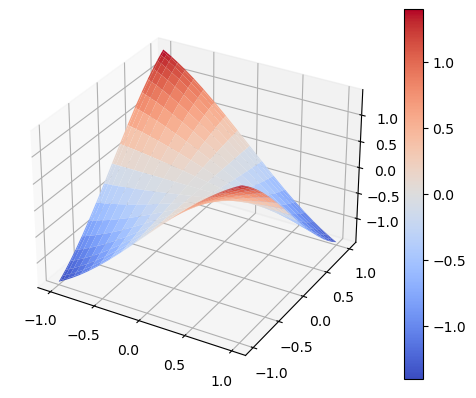

In [7]:
# Plot the source
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_surface(x_GL_mesh, y_GL_mesh, s, cmap=cm.coolwarm)
fig.colorbar(surf)

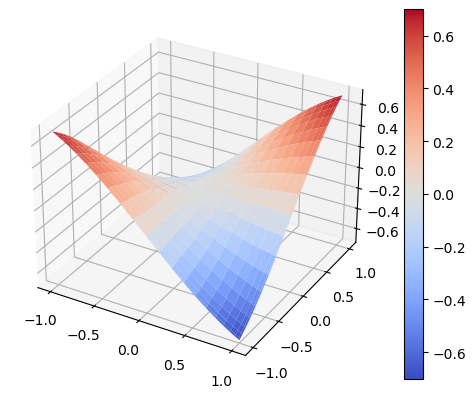

In [8]:
# Plot the solution
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_surface(x_GL_mesh, y_GL_mesh, u, cmap=cm.coolwarm)
fig.colorbar(surf)

1.2536399696116973e-10


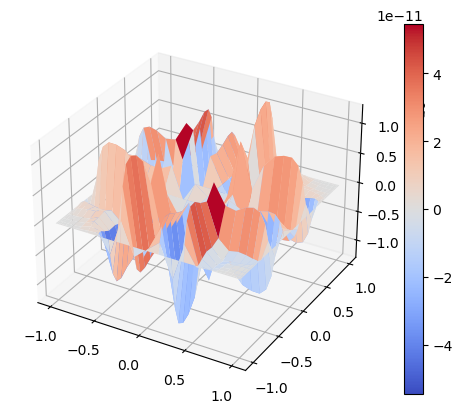

In [10]:
# Plot the error
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_surface(x_GL_mesh, y_GL_mesh, u-u_th, cmap=cm.coolwarm)
print(np.max(np.abs(u-u_th)))
fig.colorbar(surf)